#Notebook Setup

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_hub as hub
import keras_nlp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

##Load cleaned dataset

In [4]:
df = pd.read_csv('/content/data_clean.csv')
df.head()

,label,text
0,0,jurong point crazy available bugis n great wor...
1,0,ok lar Joking wif u oni
2,1,free entry 2 wkly comp win FA Cup final tkts 2...
3,0,u dun early hor u c
4,0,nah I think usf live


##Dataset Preparation

In [5]:
# Dataset Preparation
BATCH_SIZE = 32
NUM_WORDS = 7000
EPOCHS = 5
SEQUENCE_LENGTH = 130
PRESET = "distil_bert_base_en_uncased"

##Build training and validation set

In [6]:
df['text'] = df['text'].astype(str)
x_train, x_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.3, stratify=df['label'])

##Load BERT lightweight version model

In [7]:
# Load DistilBERT Preprocessor and Backbone
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(PRESET, sequence_length=SEQUENCE_LENGTH)
backbone = keras_nlp.models.DistilBertBackbone.from_preset(PRESET)

##Preprocessing

In [8]:
train_data = tf.data.Dataset.from_tensor_slices((x_train.to_numpy(), y_train.to_numpy())).batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((x_val.to_numpy(), y_val.to_numpy())).batch(BATCH_SIZE)

In [9]:
def build_distilbert_model():
    inputs = k.layers.Input(shape=(), dtype=tf.string, name="text")
    x = preprocessor(inputs)
    x = backbone(x)
    x = k.layers.GlobalAveragePooling1D()(x)
    x = k.layers.Dropout(0.1)(x)
    outputs = k.layers.Dense(1, activation='sigmoid')(x)
    return k.Model(inputs, outputs)

distilbert_model = build_distilbert_model()

In [10]:
OPTIMIZER = k.optimizers.Adam(learning_rate=2e-5)
distilbert_model.compile(
    optimizer=OPTIMIZER,
    loss=k.losses.BinaryCrossentropy(),
    metrics=[k.metrics.BinaryAccuracy(), k.metrics.Recall(), k.metrics.Precision()],
    )

In [11]:
distilbert_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)         │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ distil_bert_text_classif… │ [(None, 130), (None,   │              0 │ text[0][0]             │
│ (DistilBertTextClassifie… │ 130)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ distil_bert_backbone      │ (None, 130, 768)       │     66,362,880 │ distil_bert_text_clas… │
│ (DistilBertBackbone)      │                        │                │ distil_bert_text_clas… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 768)            │              0 │ distil_bert_backbone[… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 768)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │            769 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 66,363,649 (253.16 MB)

 Trainable params: 66,363,649 (253.16 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def scheduler(epoch, lr):
    lr = lr * np.exp(-0.1)
    return lr
lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [13]:
history = distilbert_model.fit(train_data, validation_data=val_data, epochs=EPOCHS, callbacks=[lr])

Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 861s 7s/step - binary_accuracy: 0.9347 - loss: 0.1769 - precision: 0.8120 - recall: 0.5792 - val_binary_accuracy: 0.9874 - val_loss: 0.0403 - val_precision: 0.9677 - val_recall: 0.9375 - learning_rate: 1.8097e-05
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 806s 7s/step - binary_accuracy: 0.9912 - loss: 0.0316 - precision: 0.9783 - recall: 0.9532 - val_binary_accuracy: 0.9892 - val_loss: 0.0418 - val_precision: 0.9769 - val_recall: 0.9420 - learning_rate: 1.6375e-05
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 795s 7s/step - binary_accuracy: 0.9962 - loss: 0.0147 - precision: 0.9875 - recall: 0.9829 - val_binary_accuracy: 0.9892 - val_loss: 0.0519 - val_precision: 0.9725 - val_recall: 0.9464 - learning_rate: 1.4816e-05
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 791s 6s/step - binary_accuracy: 0.9984 - loss: 0.0049 - precision: 0.9985 - recall: 0.9891 - val_binary_accuracy: 0.9833 - val_loss: 0.0974 - val_precision: 0.9900 - val_recall: 0.8839 - learning_rate: 1.3

In [21]:
distilbert_model.evaluate(val_data)

53/53 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - binary_accuracy: 0.9934 - loss: 0.0368 - precision: 0.9813 - recall: 0.9712


[0.054779961705207825,
 0.9904305934906006,
 0.9508928656578064,
 0.9770641922950745]

53/53 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1448
           1       0.98      0.95      0.96       224

    accuracy                           0.99      1672
   macro avg       0.98      0.97      0.98      1672
weighted avg       0.99      0.99      0.99      1672

F1 Score: 0.9638009049773756


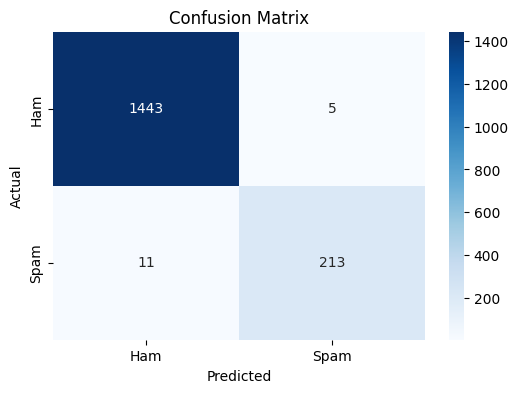

In [23]:
# Evaluation function
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(np.array(x_test))
    y_pred = np.where(y_pred < 0.5, 0, 1)  # Convert probabilities to binary labels

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("F1 Score:", f1_score(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Run evaluation
evaluate_model(distilbert_model, x_val, y_val)

